In [1]:
import numpy as np
import sys
import dapy.filters as filters
import dapy.utils.pou as pou
import dapy.ot as ot
from dapy.models import SpatialIncompressibleFluidModel
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['animation.html'] = 'html5'

## Model

The incompressible Navier-Stokes equations describe the time-evolution of the velocity field of a fluid via the following system of partial differential equations

\begin{equation}
  \partial_1\boldsymbol{u}(\boldsymbol{s}, \tau) =
  \nu \nabla \cdot \nabla \boldsymbol{u}(\boldsymbol{s}, \tau) - 
  \left(\boldsymbol{u}(\boldsymbol{s},\tau) \cdot \nabla\right) \boldsymbol{u}(\boldsymbol{s},t) -
  \nabla w(\boldsymbol{s}, \tau)  + \boldsymbol{f}(\boldsymbol{s},\tau)
\end{equation}

where (assuming two spatial dimension) $\boldsymbol{u}(\boldsymbol{s}, \tau) = [u_0(\boldsymbol{s},\tau),u_1(\boldsymbol{s},t)]^\mathsf{T}: \mathcal{S} \times \mathcal{T} \to \mathbb{R}^2$ is the velocity field, $\mathbf{s} = [s_0, s_1]^\mathsf{T} \in \mathcal{S}$ is the spatial coordinate, $\tau \in \mathcal{T}$ is the time coordinate, $\nu$ is the kinematic viscosity, $\nabla = \left[ \partial_{0,0},~\partial_{0,1}\right]^\mathsf{T}$ is the del partial derivative operator, $w(\boldsymbol{s},\tau) \in \mathbb{R}^{+}$ is the specific thermodynamic work field and $\boldsymbol{f}(\boldsymbol{s},\tau) \in \mathbb{R}^2$ is an external force field. The flow is further subject to the incompressibility condition (equivalently requiring a divergence-free flow)

\begin{equation}
  \nabla \cdot \boldsymbol{u}(\boldsymbol{s},\tau) = 0 ~~\forall \boldsymbol{s} \in \mathcal{S},~\tau \in \mathcal{T}.
\end{equation}

In the absence of an external force field, the dynamics consist of a combination of the diffusive $\nu \nabla \cdot \nabla \boldsymbol{u}(\boldsymbol{s}, \tau)$ term which models viscous diffusion and the (self-)advection term  $\left(\boldsymbol{u}(\boldsymbol{s},\tau) \cdot \nabla\right) \boldsymbol{u}(\boldsymbol{s},\tau)$, with the specific work field $w(\boldsymbol{s},\tau)$ being implicitly defined by solving for the incompressibility condition.

If we define the scalar vorticity as the curl of the velocity field 
\begin{equation}
   v(\boldsymbol{s},\tau) = \nabla \times \boldsymbol{u}(\boldsymbol{s},\tau) = 
  \partial_{0,0} u_1(\boldsymbol{s},\tau) - \partial_{0,1} u_0(\boldsymbol{s},\tau)
\end{equation}
then by taking the curl of the incompressible Navier-Stokes equation we can derive the vorticity transport equation
\begin{equation}
  \partial_1 v(\boldsymbol{s}, \tau) =
  \nu \nabla \cdot \nabla v(\boldsymbol{s}, \tau) - 
  \left(\mathsf{u}\circ v(\boldsymbol{s},\tau) \cdot \nabla\right) v(\boldsymbol{s},\tau) +
  g(\boldsymbol{s},\tau)
\end{equation}
where $g(\boldsymbol{s},\tau) = \nabla \times \boldsymbol{f}(\boldsymbol{s},\tau)$ and $\mathsf{u}$ is an implicitly defined operator giving the velocity field corresponding to a voriticity field. Reparameterising the velocity field in terms of the vorticity removes the need to constrain the dynamics to the space of divergence-free velocity fields.

Here we consider a stochastically forced model, which we can either consider on an intuitive level as corresponding to the forcing term $g(\boldsymbol{s},\tau)$ being a stochastic process or more formally we consider the following stochastic partial differential equation system

\begin{equation}
  \mathrm{d} V(\boldsymbol{s}, \tau) =
  \left( \nu \nabla \cdot \nabla V(\boldsymbol{s}, \tau) - 
  \left(\mathsf{u} \circ V(\boldsymbol{s},\tau) \cdot \nabla\right) V(\boldsymbol{s},\tau) \right)
  \mathrm{d}\tau +
  \kappa(s) \circledast \mathrm{d}W(\boldsymbol{s},\tau)
\end{equation}

where $V(\boldsymbol{s}, \tau)$ is the stochastic vorticity process, $\kappa$ is a spatial smoothing kernel and $W(\boldsymbol{s},\tau)$ is a space-time white noise (Wiener) process.

For computational simplicity, here we consider simulation on a two-dimensional torus, i.e. with periodic boundary conditions, as this will allow a Fourier spectral scheme to be used for the spatial discretisation. The spatial domain is defined as $\mathcal{S} = [0, S]^2$ with the top and bottom edges, and left and right edges identified with each other. The spatial domain is discretised on a rectilinear grid of $M^2$ points

\begin{equation}
  \boldsymbol{s}^{(i,j)} = \left[\frac{iS}{M},\frac{jS}{M}\right] 
  ~~\forall i,j \in \lbrace 0 \dots M-1 \rbrace^2.
\end{equation}

and an equispaced discretisation in time with time step $\Delta$ is used. An operator splitting method is used to simulate the dynamics at discrete time steps $\tau = \Delta, 2\Delta, \dots$, with separate schemes used to model the deterministic diffusion and advection terms and stochastic Wiener process term. The diffusion term is simulated in the spectral domain by approximating the spatial derivatives (Laplacian) using a FFT based Fourier spectral method [1] and exactly solving the resulting linear system in spectral space for a fixed time-step. The advection terms are simulated in the spatial domain using a semi-Lagrangian scheme with backward-forward error correction for second-order accuracy [2]. An Euler-Maruyama discretisation is used to update for the Wiener process increment term.

The smoothing kernel $\kappa$ Fourier coefficients are assumed to be

$$\tilde{\kappa}_{k,l} = \sigma_x \exp(-(\omega_{0,k}^2 + \omega_{1,l}^2) \ell^2) (M / S) $$

where $\omega_{0,k}, \omega_{1,l}$ are the spatial frequencies, $\sigma_x$ is a parameter controlling the amplitude and $\ell$ a parameter controlling the length scale. As well as being convolved with the noise added to the state at each time step from the discretisation of the Wiener process term, the smoothing kernel is also used to generate the initial state $\boldsymbol{X}_0$ by convolving a a white noise vector with the kernel (but with a different amplitude parameter $\sigma_{x_0}$ rather than $\sigma_x$).

Defining the following notation for the spatially and temporally discretised vorticity

\begin{equation}
   V^{(i,j)}_t = V(\boldsymbol{s}^{(i,j)}, t\Delta)
  \qquad
  \forall i,j \in \lbrace 0 \dots M-1 \rbrace^2
\end{equation}

then the overall system state $\boldsymbol{X}_t \in \mathbb{R}^{M^2}$ at a discrete time index $t$ is defined as the flattened discretised vorticity field

\begin{equation}
  \boldsymbol{X}_t = \left[ 
    V^{(0,0)}_t, V^{(0,1)}_t \cdots V^{(0,M)}_t, V^{(1,0)}_t \cdots V^{(M,M)}
  \right]^\mathsf{T}.
\end{equation}

The observations $\boldsymbol{Y}_t \in \mathbb{R}^{(M / N)^2}$ are assumed to correspond to a noisy factor $N$ spatial subsampling of the vorticity field i.e.

\begin{equation}
  \boldsymbol{Y}_t = \left[
    V^{(0,0)}_t, V^{(0,N)}_t, V^{(0,2N)}_t \cdots V^{(0,M)}_t, V^{(N,0)}_t \cdots V^{(M,M)}_t
  \right]^\mathsf{T} + \boldsymbol{\epsilon}_t
  \quad\textrm{with}\quad \boldsymbol{\epsilon}_t \sim \mathcal{N}(\mathbf{0}_{(M/N)^2},\sigma_y^2\mathbb{I}_{(M/N)^2}).
\end{equation}

Here we use the parameters $M = 128$, $N = 4$, $\Delta = 0.25$, $S=5$, $\nu = 10^{-4}$, $\sigma_y = 0.1$, $\sigma_{x_0} = 5 \times 10^{-2}$, $\sigma_x = 4 \times 10^{-3}$ and  $\ell = 2 \times 10^{-3}$.


### References

  1. Stam, Jos. A simple fluid solver based on the FFT.
     Journal of graphics tools 6.2 (2001): 43-52.
  2. Kim, ByungMoon, Yingjie Liu, Ignacio Llamas, and Jarek Rossignac.
     FlowFixer: using BFECC for fluid simulation. Proceedings of the First
     Eurographics conference on Natural Phenomena. Eurographics
     Association, (2005).

In [2]:
model_params = {
    'spatial_mesh_shape': (128, 128),
    'observation_subsample': 4,
    'time_step': 0.25,
    'domain_size': (5, 5),
    'viscous_diffusion_coeff': 1e-4,
    'observation_noise_std': 0.1,
    'initial_state_amplitude': 5e-2,
    'state_noise_amplitude': 4e-3,
    'state_noise_length_scale': 2e-3,
}
model = SpatialIncompressibleFluidModel(**model_params)

## Generate data from model

In [3]:
#observation_time_indices = np.arange(1000, 2001, 10)
observation_time_indices = np.arange(500, 1501, 10)
seed = 20200727
rng = np.random.default_rng(seed)
state_sequence, observation_sequence = model.sample_state_and_observation_sequences(
    rng, observation_time_indices, return_states_at_all_times=False)

Sampling: 100%|██████████|1501/1501 [00:06<00:00, 214.47time-steps/s]

In [15]:
observation_sequence.shape
#model.mesh_node_coords

(101, 1024)

In [4]:
def animate_fields(field_sequences):
    fig, axes = plt.subplots(1, len(field_sequences), figsize=(4 * len(field_sequences), 4))
    extent = (0, model.domain_extents[0], 0, model.domain_extents[1])
    im_artists = [
        ax.imshow(field_sequence[-1], cmap='viridis', extent=extent)
        for ax, field_sequence in zip(axes, field_sequences.values())
    ]
    for ax, label in zip(axes, field_sequences.keys()):
        ax.set(xlabel='Spatial coordinate $s_0$', ylabel='Spatial coordinate $s_1$')
        ax.set_title(label)
    fig.tight_layout()

    def update(i):
        for im, field_sequence in zip(im_artists, field_sequences.values()):
            im.set_data(field_sequence[i])
        return im_artists
    
    plt.close(fig)
    return animation.FuncAnimation(
        fig, update, min(len(seq) for seq in field_sequences.values()),
        interval=25, blit=True)

In [5]:
observation_mesh_shape = (
    model.mesh_shape[0] // model.observation_subsample, 
    model.mesh_shape[1] // model.observation_subsample)
animate_fields({
    'True state (voriticity) field': state_sequence.reshape((-1,) + model.mesh_shape), 
    'Noisy observations': observation_sequence.reshape((-1,) + observation_mesh_shape)
})

[ 500  510  520  530  540  550  560  570  580  590  600  610  620  630
  640  650  660  670  680  690  700  710  720  730  740  750  760  770
  780  790  800  810  820  830  840  850  860  870  880  890  900  910
  920  930  940  950  960  970  980  990 1000 1010 1020 1030 1040 1050
 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190
 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330
 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470
 1480 1490 1500]


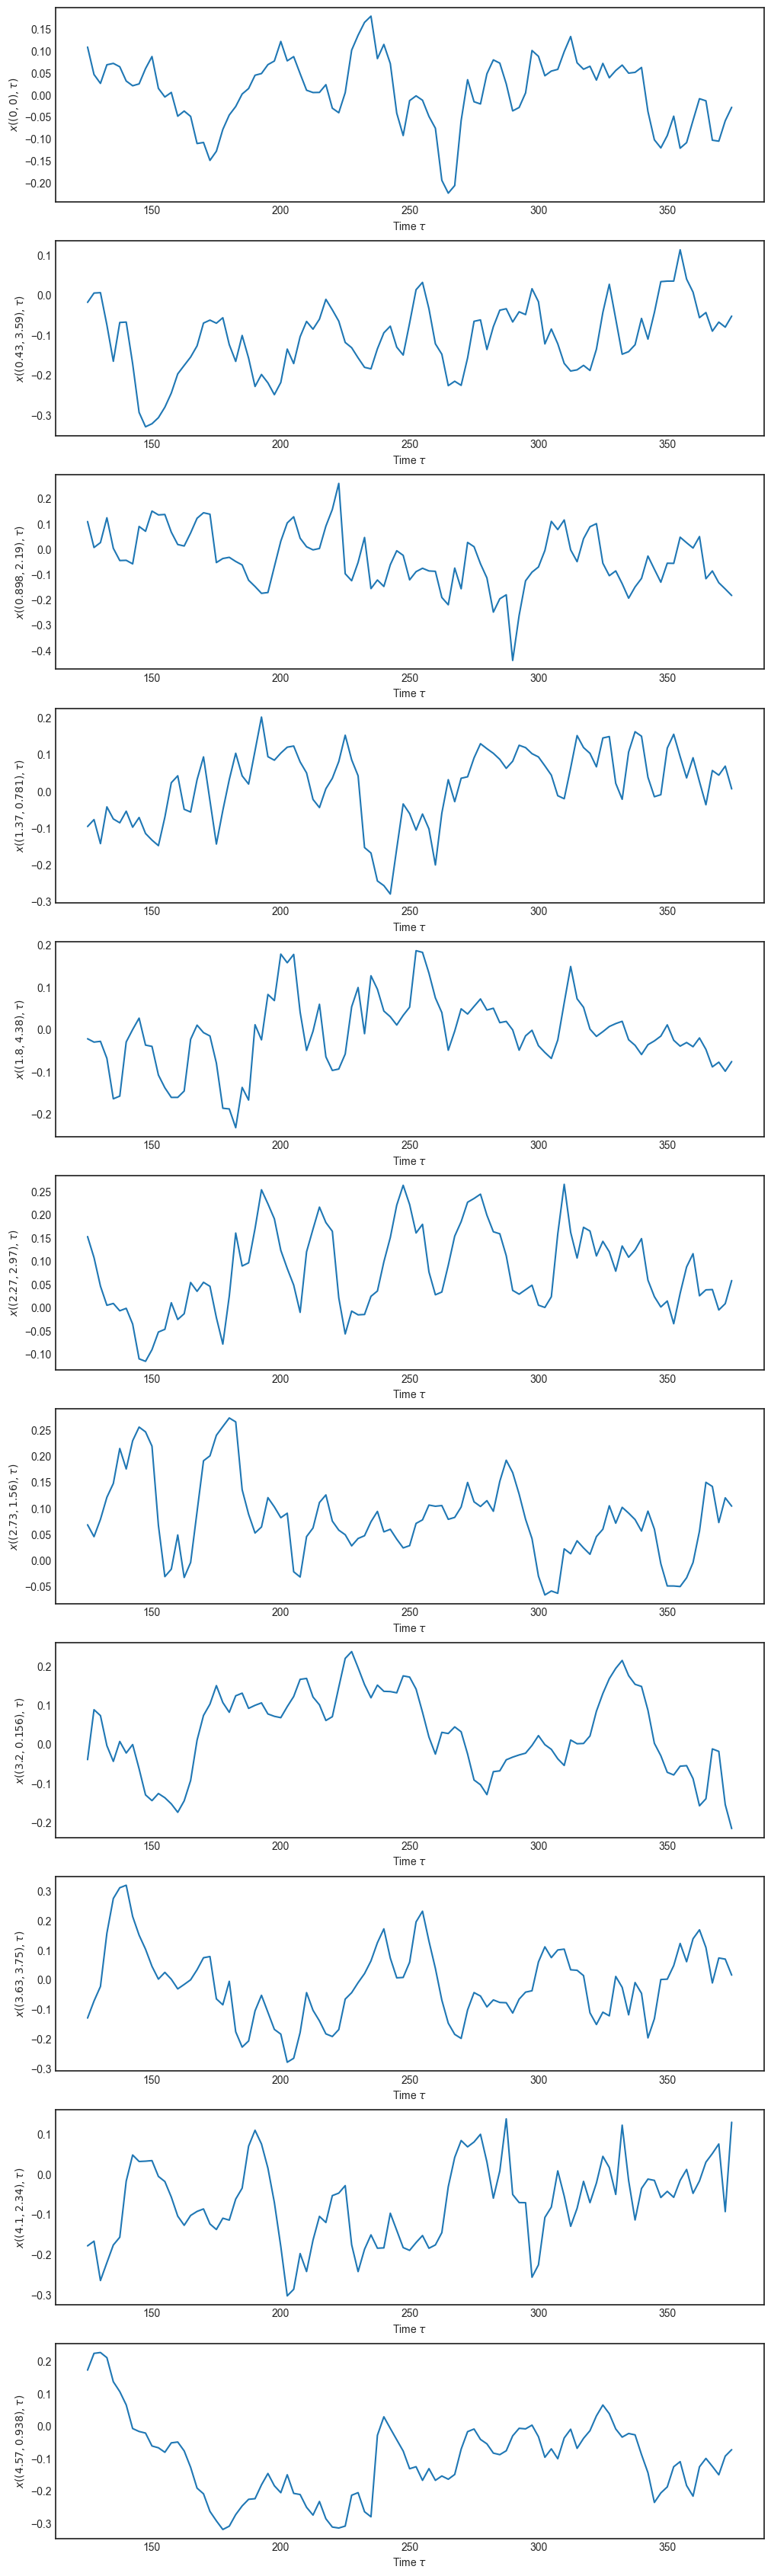

In [13]:
num_time_indices = observation_time_indices.max()
times = np.linspace(0, num_time_indices * model_params['time_step'], num_time_indices + 1)
plot_space_indices = range(0, model.mesh_size, 1500)
fig, axes = plt.subplots(len(plot_space_indices), 1, 
                         figsize=(12, len(plot_space_indices) * 4))
print(observation_time_indices)
for s, ax in zip(plot_space_indices, axes):
    _ = ax.plot(times[observation_time_indices], state_sequence[:, s])
    ax.set_xlabel('Time $\\tau$')
    ax.set_ylabel(f'$x(({model.mesh_node_coords[s, 0]:.3g}, {model.mesh_node_coords[s, 1]:.3g}), \\tau)$')

## Infer state from observations

In [32]:
def plot_results(results, space_indices, observation_time_indices, state_sequence=None, 
                 plot_particles=False, plot_region=True, 
                 particle_skip=2, trace_alpha=0.5):
    fig, axes = plt.subplots(nrows=len(space_indices), ncols=1, sharex=True, 
                             figsize=(12, len(space_indices) * 3))
    for i, ax in zip(space_indices, axes):
        ax.plot(observation_time_indices, results['state_mean_sequence'][:, i], 'g-', lw=1, label='Est. mean')
        if plot_region:
            ax.fill_between(
                observation_time_indices,
                results['state_mean_sequence'][:, i] - 3 * results['state_std_sequence'][:, i],
                results['state_mean_sequence'][:, i] + 3 * results['state_std_sequence'][:, i],
                alpha=0.25, color='g', label='Est. mean ± 3 standard deviation'
            )
        if plot_particles:
            ax.plot(observation_time_indices, results['state_particles_sequence'][:, ::particle_skip, i], 
                    'r-', lw=0.25, alpha=trace_alpha)
            lines[0].set_label('Particles')
        if state_sequence is not None:
            ax.plot(observation_time_indices, state_sequence[:, i], 'k--', label='Truth')
        ax.set_ylabel(f'$x_{{{i},t}}$')
        ax.legend(loc='upper center', ncol=4)
    ax.set_xlabel('Time index $t$')
    fig.tight_layout()
    return fig, axes

### Ensemble transform Kalman filter (square root filter)

In [41]:
etkf = filters.EnsembleTransformKalmanFilter()

In [42]:
results_etkf = etkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=50, rng=rng, return_particles=True)

Filtering: 100%|██████████|1501/1501 [07:21<00:00, 3.40time-steps/s]

In [35]:
animate_fields({
    'True state (voriticity) field': state_sequence.reshape((-1,) + model.mesh_shape), 
    'Estimated mean state field': results_etkf['state_mean_sequence'].reshape((-1,) + model.mesh_shape)
})

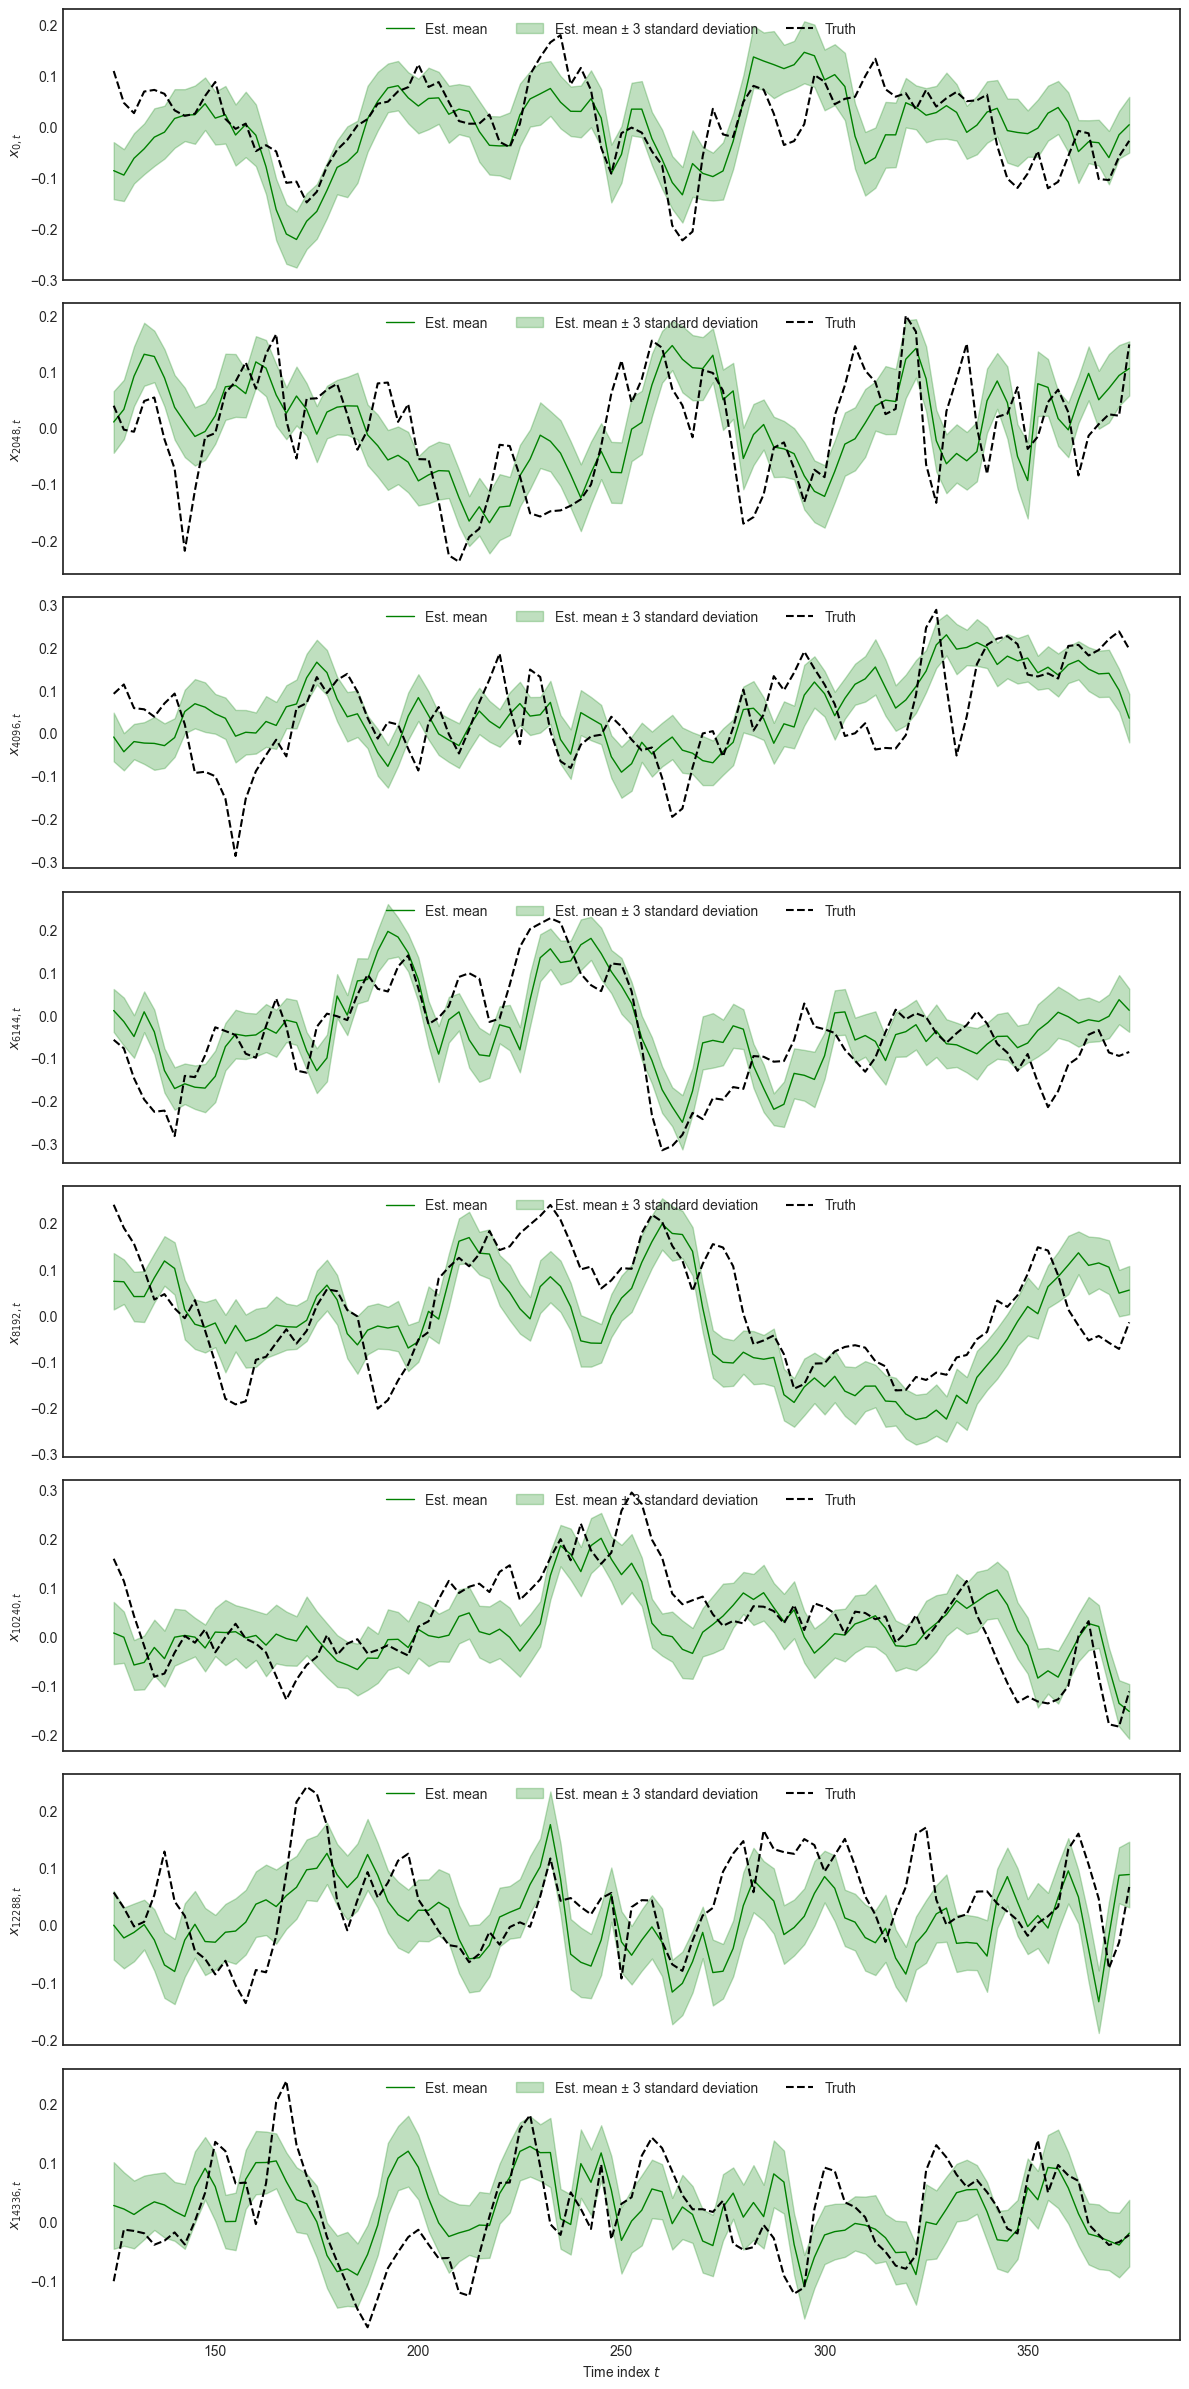

In [36]:
fig, axes = plot_results(
    results_etkf, range(0, model.dim_state, model.dim_state // 8),  
    times[observation_time_indices], state_sequence)

### Local ensemble transform Kalman filter

In [37]:
letkf = filters.LocalEnsembleTransformKalmanFilter(localisation_radius=0.4)

In [38]:
results_letkf = letkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=50, rng=rng, return_particles=False)

Filtering:  11%|█▏        |167/1501 [00:47<06:18, 3.52time-steps/s]

KeyboardInterrupt: 

In [ ]:
animate_fields({
    'True state (voriticity) field': state_sequence.reshape((-1,) + model.mesh_shape), 
    'Estimated mean state field': results_letkf['state_mean_sequence'].reshape((-1,) + model.mesh_shape)
})

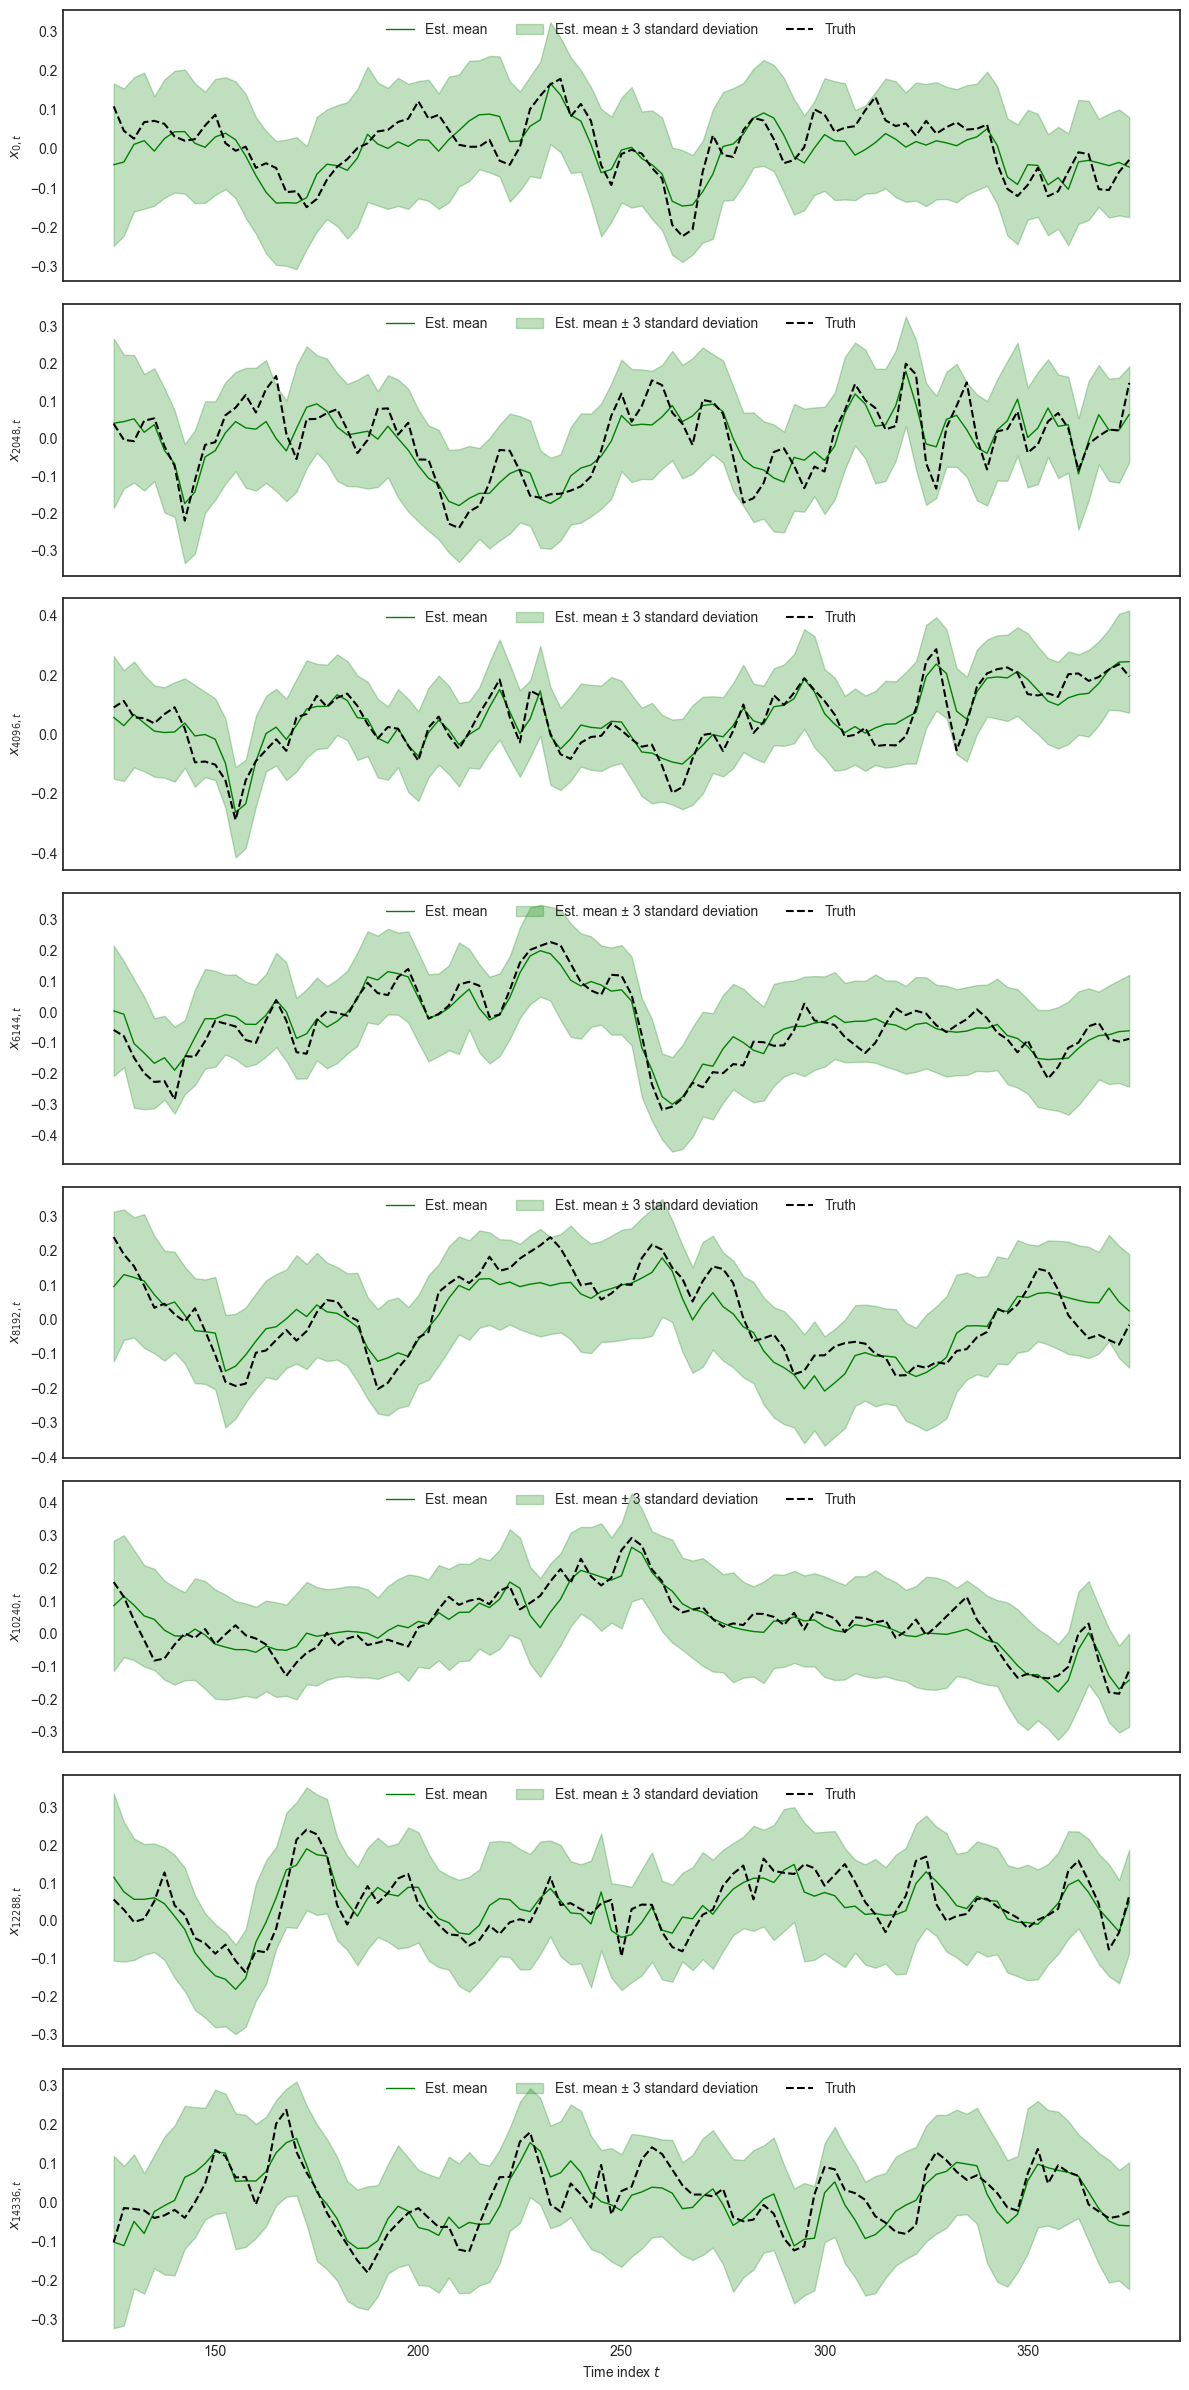

In [ ]:
fig, axes = plot_results(
    results_letkf, range(0, model.dim_state, model.dim_state // 8),  
    times[observation_time_indices], state_sequence)

### Local ensemble transform particle filter

In [ ]:
letpf = filters.ScalableLocalEnsembleTransformParticleFilter(
    localisation_radius=0.4,
    optimal_transport_solver_kwargs={'num_thread': 4},
    calculate_cost_matrices_func_kwargs={'num_thread': 4}
)

In [ ]:
results_letpf = letpf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=50, rng=rng, return_particles=False)

Filtering: 100%|██████████|1501/1501 [25:47<00:00, 1.03s/time-steps]

In [ ]:
animate_fields({
    'True state (voriticity) field': state_sequence.reshape((-1,) + model.mesh_shape), 
    'Estimated mean state field': results_letpf['state_mean_sequence'].reshape((-1,) + model.mesh_shape)
})

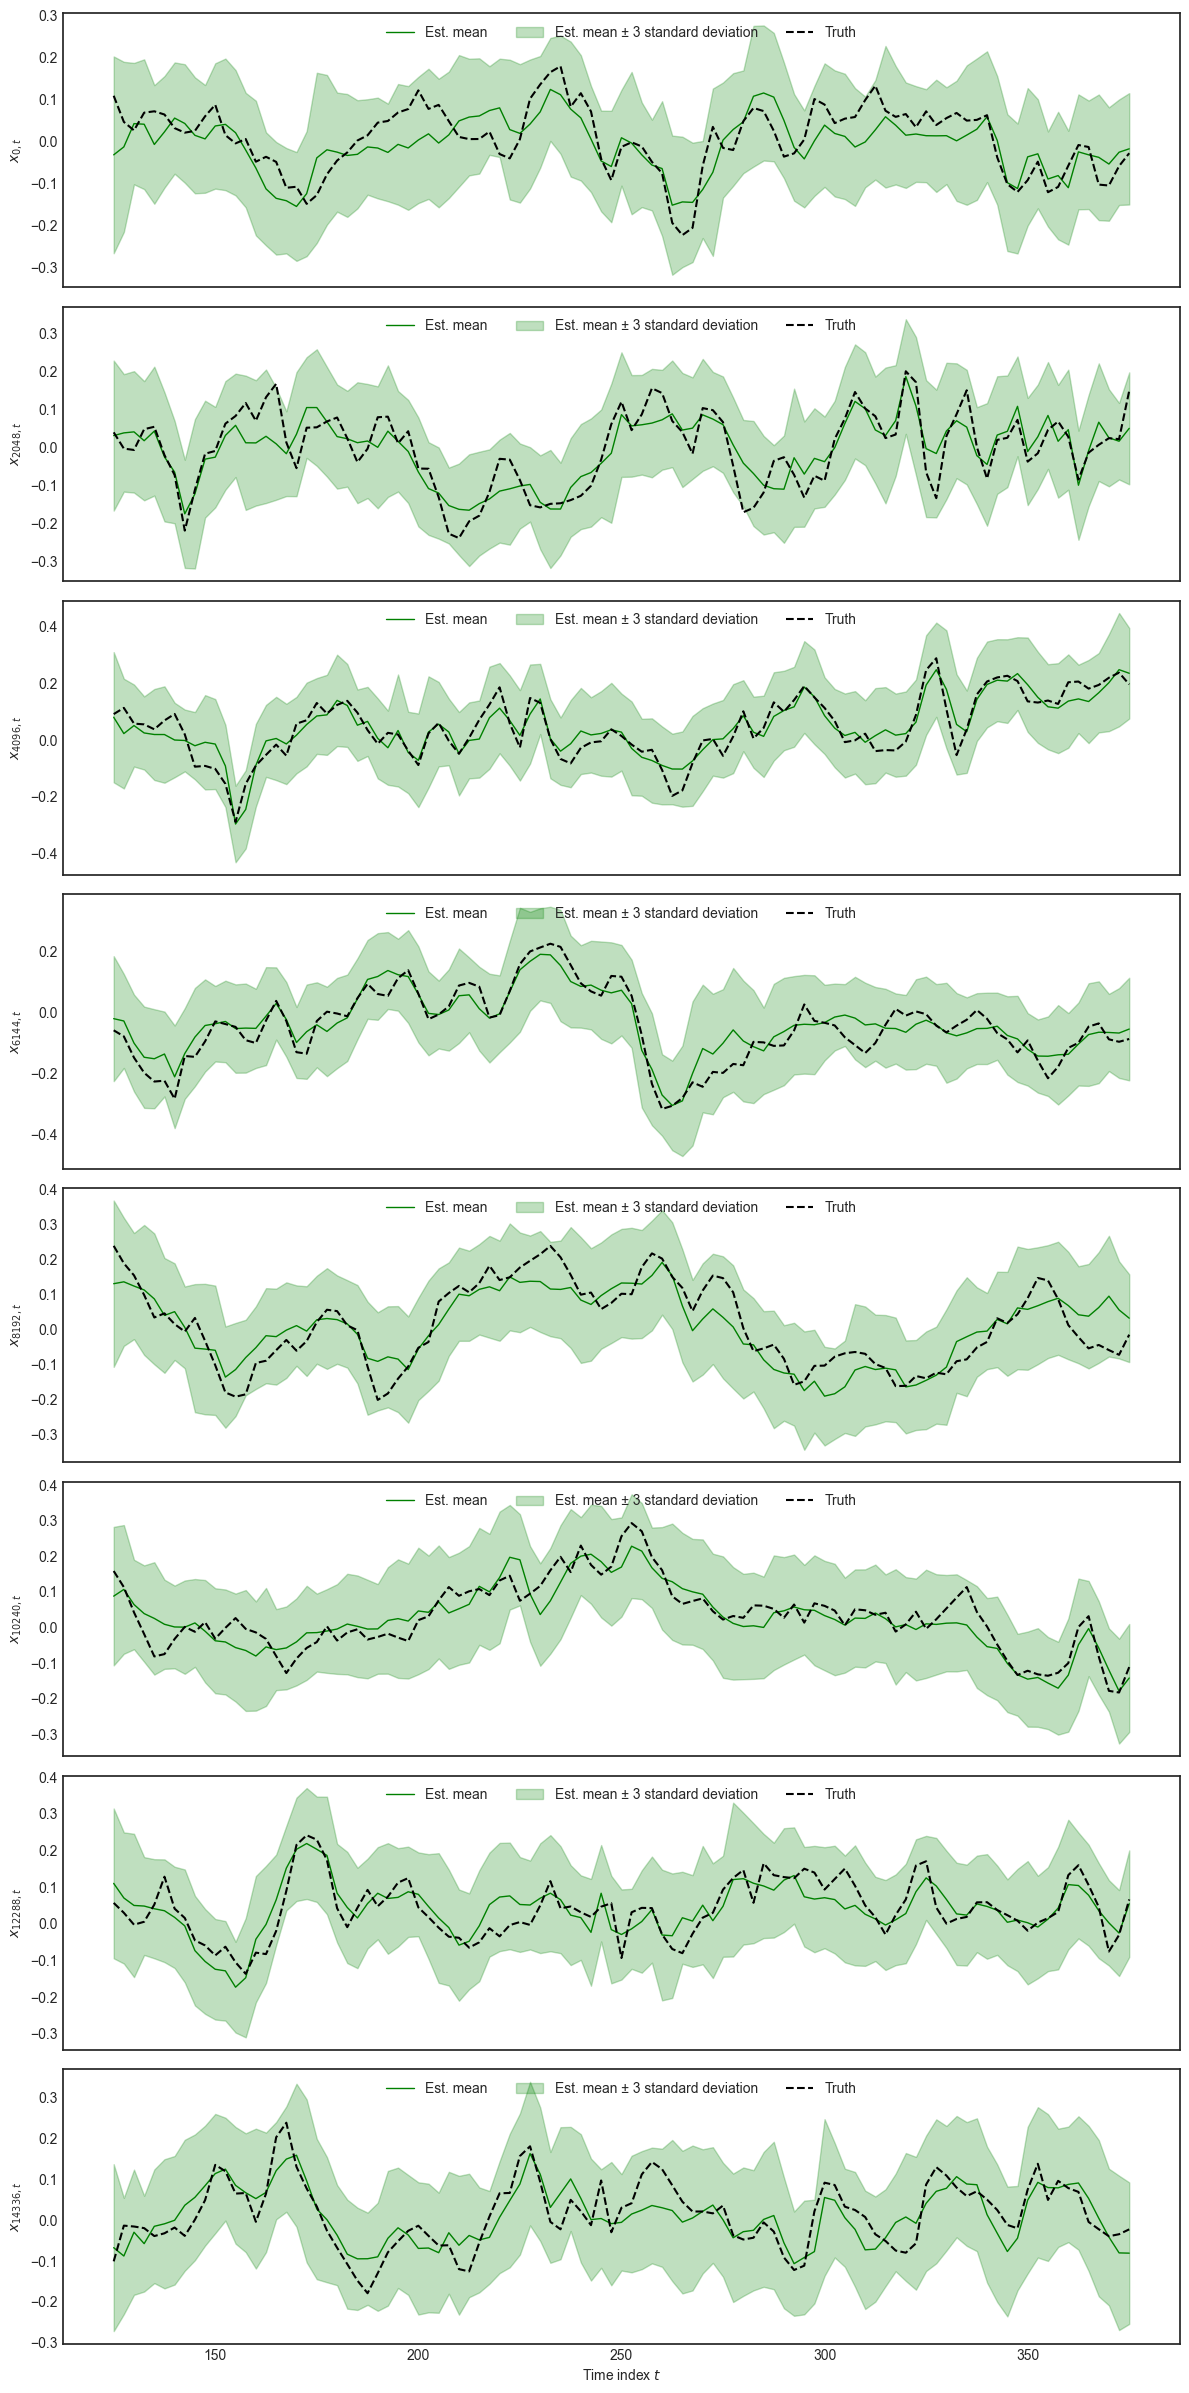

In [ ]:
fig, axes = plot_results(
    results_letpf, range(0, model.dim_state, model.dim_state // 8),  
    times[observation_time_indices], state_sequence)

### Scalable localised ensemble transform particle filter

In [ ]:
partition_of_unity = pou.SmoothedBlock2dPartitionOfUnityBasis(
    model, (32, 32), kernel_halfwidth=2)

In [ ]:
sletpf = filters.ScalableLocalEnsembleTransformParticleFilter(
    localisation_radius=0.1, partition_of_unity=partition_of_unity,
    optimal_transport_solver_kwargs={'num_thread': 4},
    calculate_cost_matrices_func_kwargs={'num_thread': 4}
)

In [ ]:
results_sletpf = sletpf.filter(
    model, observation_sequence, observation_time_indices , 
    num_particle=50, rng=rng, return_particles=False)

Filtering: 100%|██████████|1501/1501 [14:30<00:00, 1.72time-steps/s]

In [ ]:
animate_fields({
    'True state (voriticity) field': state_sequence.reshape((-1,) + model.mesh_shape), 
    'Estimated mean state field': results_sletpf['state_mean_sequence'].reshape((-1,) + model.mesh_shape)
})

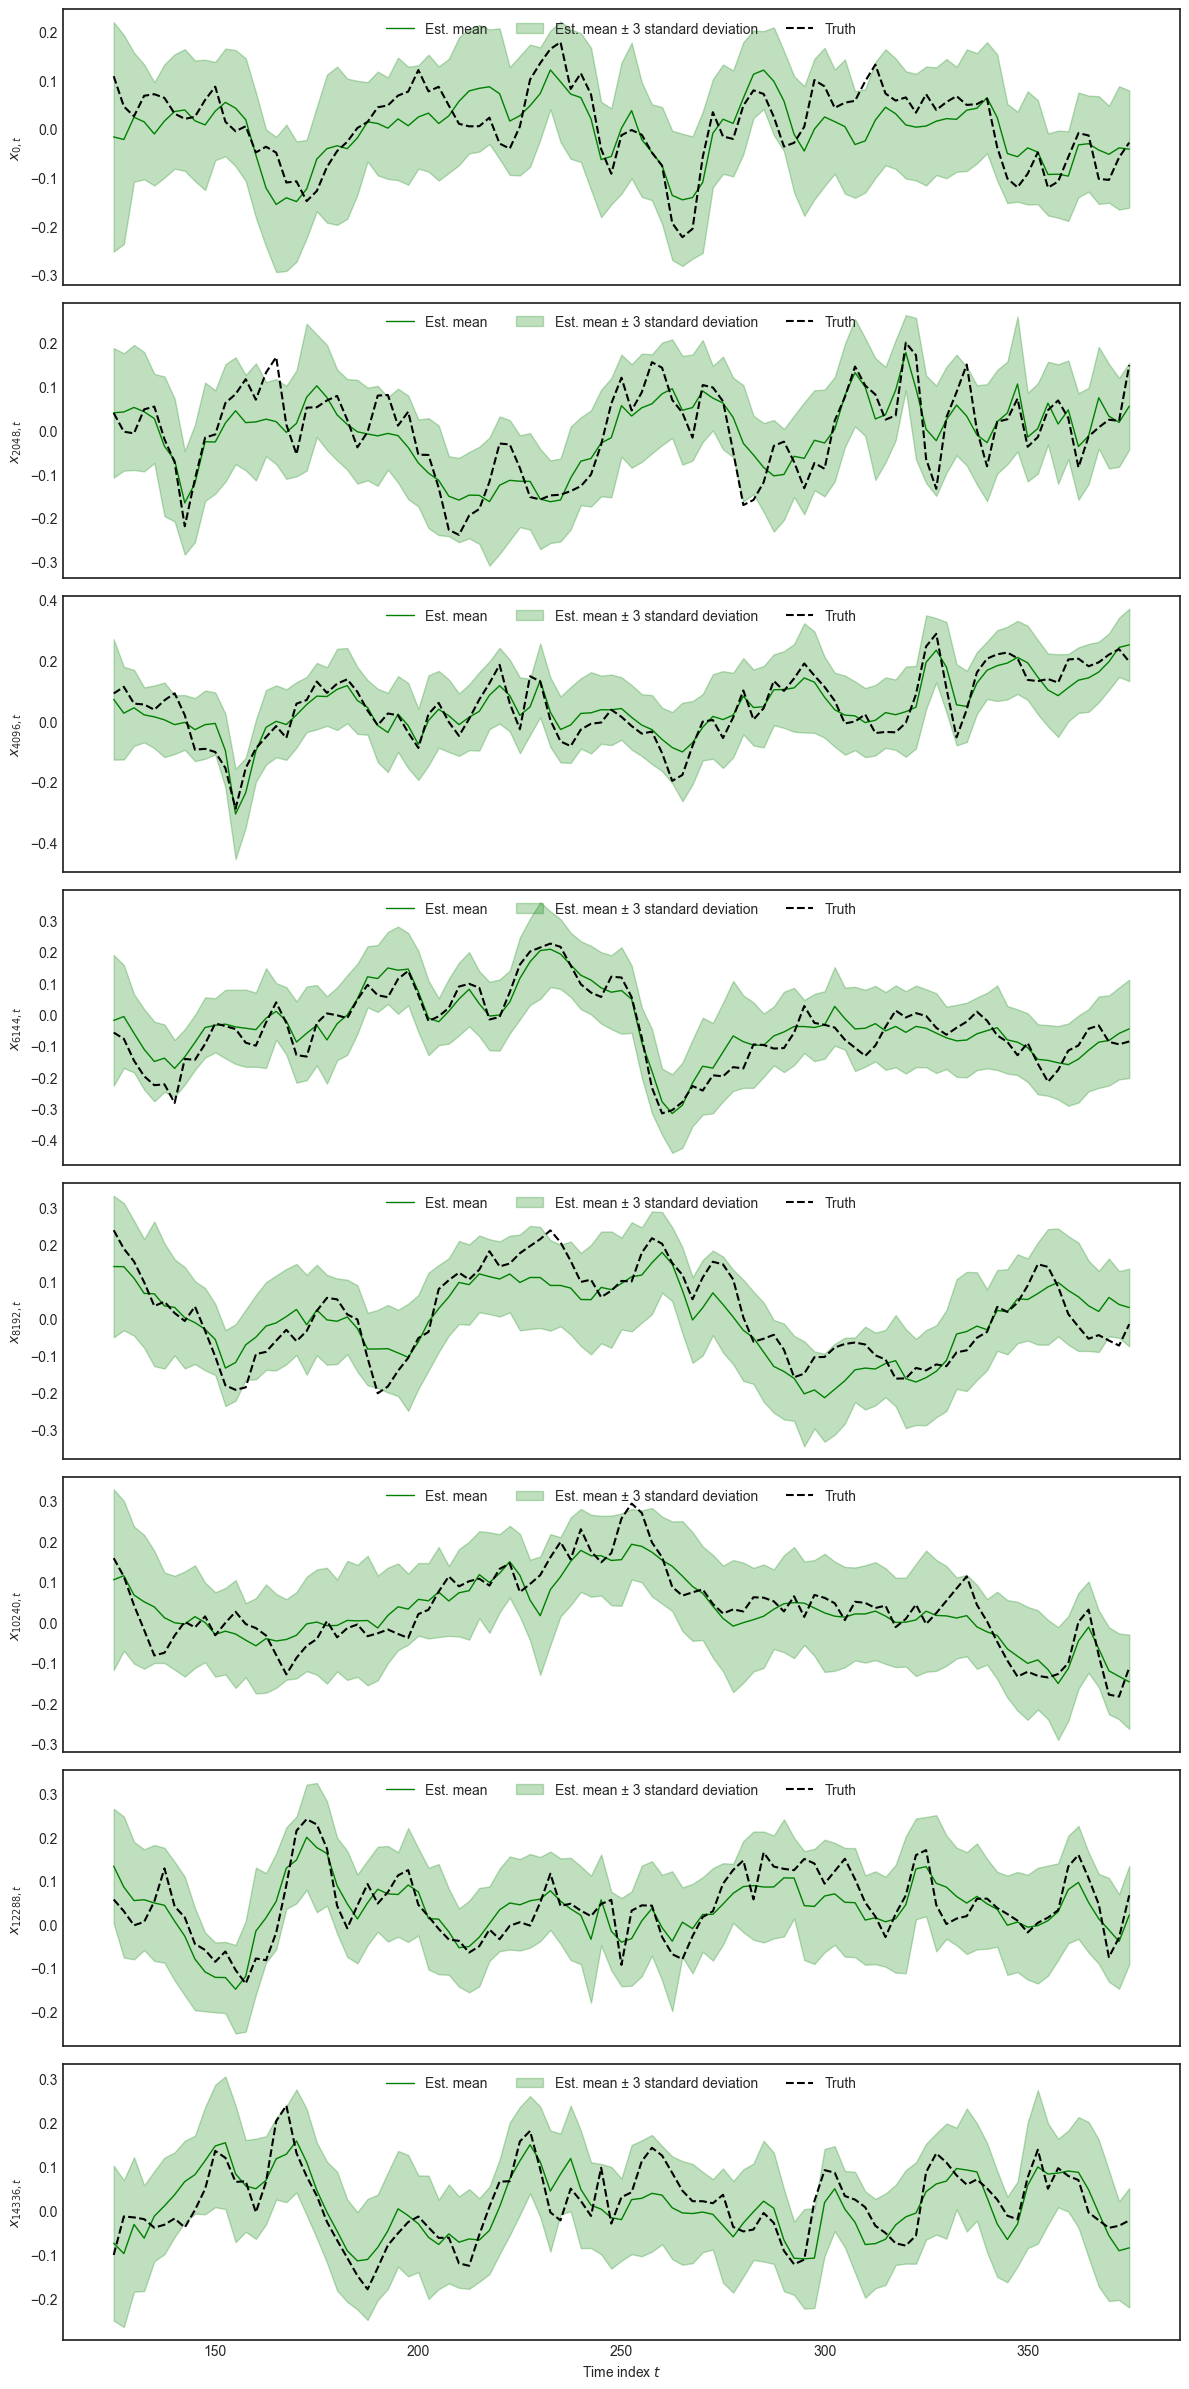

In [ ]:
fig, axes = plot_results(
    results_sletpf, range(0, model.dim_state, model.dim_state // 8),  
    times[observation_time_indices], state_sequence)